/home/qinyaomou/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.32064e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


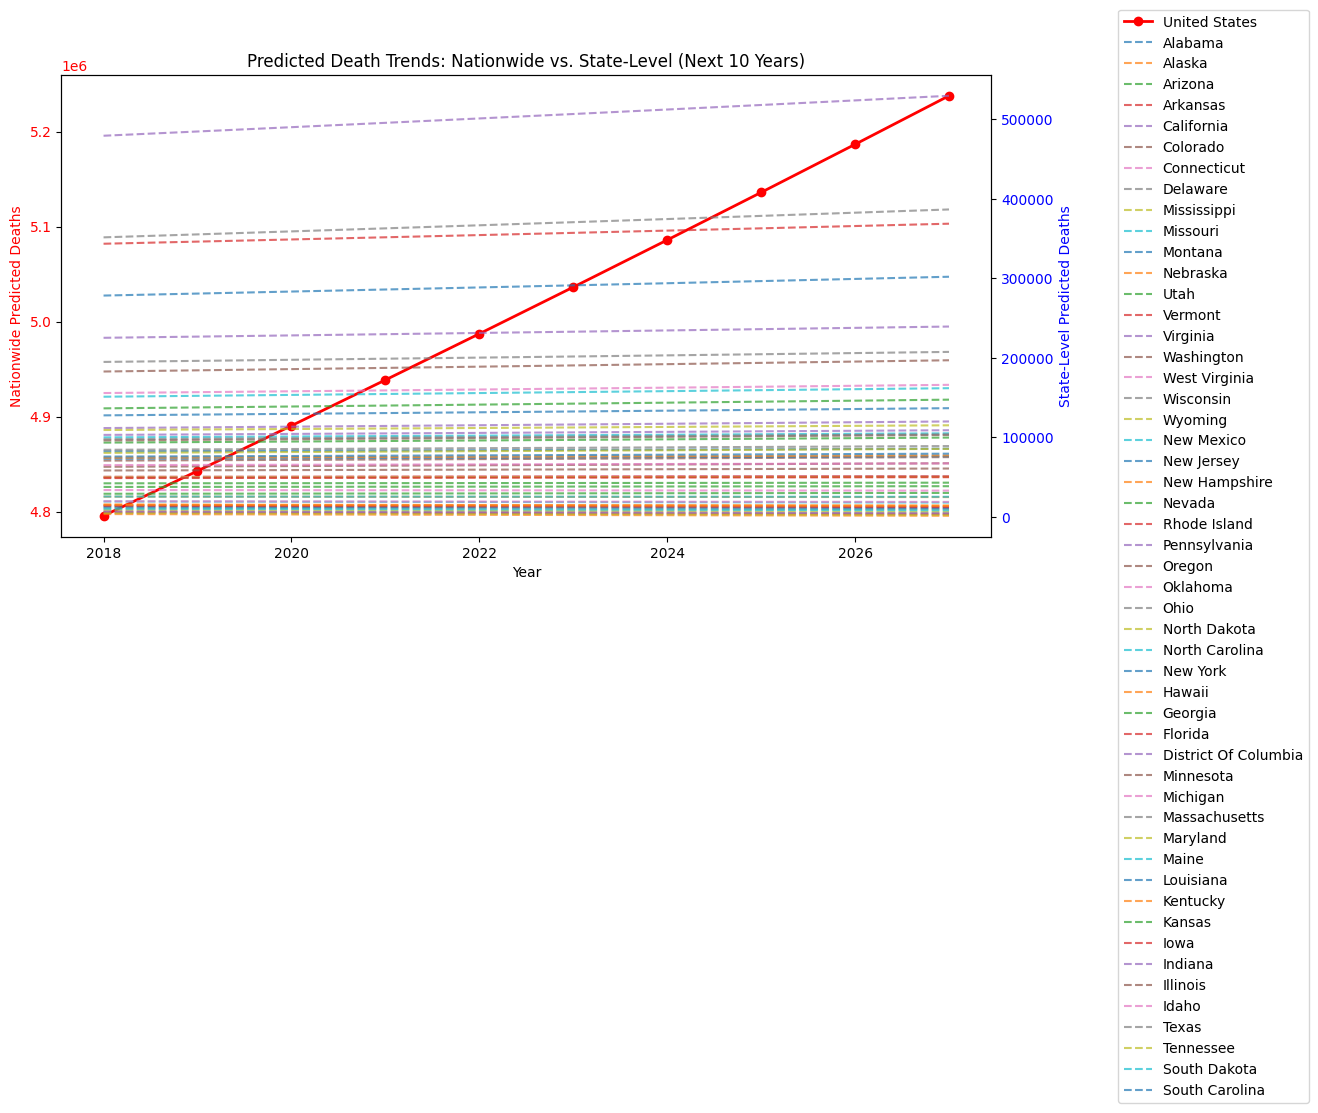

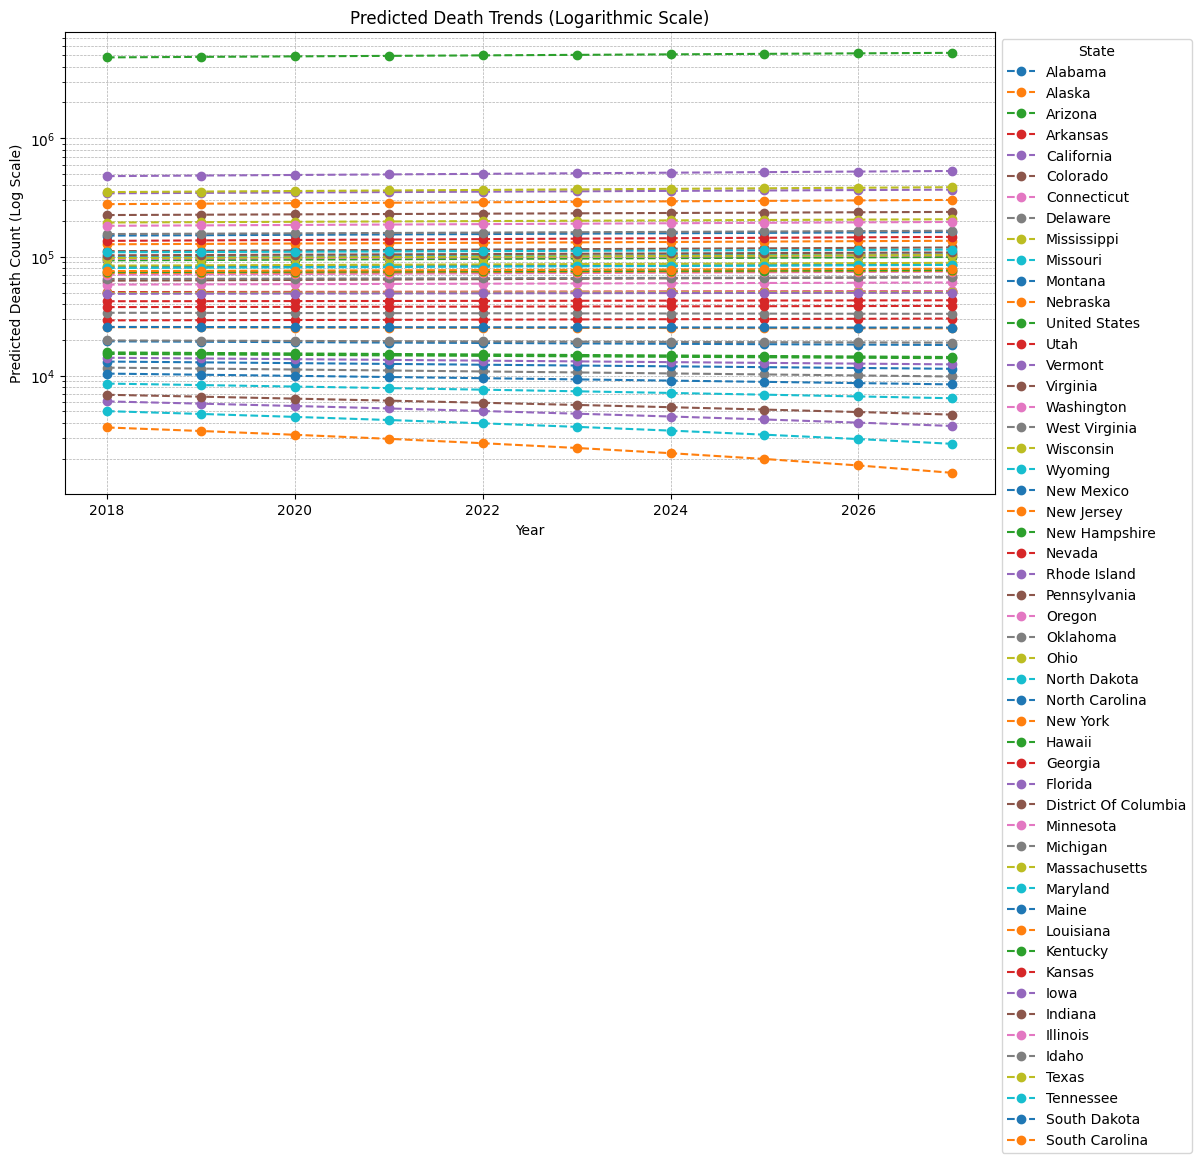

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from visualization import plot_dual_axis_trends, plot_log_scale_trends

# This regression model aggregate death counts for all causes
# Predict future death counts by nationwide and states
# Load dataset
df = pd.read_csv('../data/processed/US_Deaths_Populations.csv', sep=',')

# Aggregate death counts for all causes
df_agg = df.groupby(["Year", "State"]).agg({
    "Deaths": "sum",  # Sum deaths for all causes
    "Population": "first"  # Population remains the same per state
}).reset_index()

# Write aggregated data in a new csv
df_agg.to_csv('../data/processed/US_and_States_Total_Deaths.csv', index=False)

# One-hot encode the State column
encoder = OneHotEncoder(sparse_output=False)
state_encoded = encoder.fit_transform(df_agg[['State']])
state_encoded_df = pd.DataFrame(state_encoded, columns=encoder.get_feature_names_out(['State']))

# Combine the encoded state columns with the original dataframe
df_encoded = pd.concat([df_agg, state_encoded_df], axis=1).drop(columns=['State'])

# Define features (X) and target (y)
X = df_encoded.drop(columns=['Deaths'])
y = df_encoded['Deaths']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Prepare future data for predictions
future_years = np.arange(2018, 2028)  # Years 2018 to 2027
future_states = encoder.categories_[0]  # List of all states

# Create a DataFrame for future predictions
future_data = pd.DataFrame(
    [(year, state) for year in future_years for state in future_states],
    columns=['Year', 'State']
)

# Assume a linear population growth for simplicity (this should be replaced with actual projections)
population_growth_rate = 0.01  # Example: 1% annual growth
latest_population = df.groupby('State')['Population'].last()  # Latest known population per state

future_data['Year'] = future_data['Year'].astype(int)
latest_population = df.groupby(['Year', 'State'])['Population'].last().reset_index()

# Assign population estimates to future data
future_data['Population'] = future_data.apply(
    lambda row: latest_population[
        (latest_population['State'] == row['State']) & (latest_population['Year'] == df['Year'].max())
    ]['Population'].values[0] * (1 + population_growth_rate) ** (row['Year'] - df['Year'].max()),
    axis=1
)

# One-hot encode the State column in future data
future_state_encoded = encoder.transform(future_data[['State']])
future_state_encoded_df = pd.DataFrame(future_state_encoded, columns=encoder.get_feature_names_out(['State']))

# Combine the encoded state columns with the future data
future_data_encoded = pd.concat([future_data, future_state_encoded_df], axis=1).drop(columns=['State'])

# Ensure future data has the same columns as the training data
missing_cols = set(X_train.columns) - set(future_data_encoded.columns)
for col in missing_cols:
    future_data_encoded[col] = 0
future_data_encoded = future_data_encoded[X_train.columns]

# Predict future deaths
future_data['Predicted Deaths'] = ridge_model.predict(future_data_encoded)

# Display predictions
# print(future_data[['Year', 'State', 'Population', 'Predicted Deaths']])

# Write prediction data in a new csv file
future_data.to_csv('../data/processed/US_and_States_Total_Deaths_Prediction.csv', index=False)

# Visualize the result
plot_dual_axis_trends(future_data)
plot_log_scale_trends(future_data)